<h1 align="center">First of all -- Checking Questions</h1> 

**Вопрос 1**: Можно ли использовать сверточные сети для классификации текстов? Если нет обоснуйте :D, если да то как? как решить проблему с произвольной длинной входа?

Можно. Делаем ембеддинг слов в S мерное про-во. Пусть в предложении N слов (N не фиксируется).
Тогда тексту можно сопоставить матрицу SxN. Делаем свертку с фильтрами размера S x n где n не велико (2, 3, 4, 5) На выходе получаем векторы длиной (N-n+1). Ищем в каждом векторе максимум. В итоге получаем вектор фиксированный длины (дляна равна числу фильтров). 

**Вопрос 2**: Чем LSTM лучше/хуже чем обычная RNN?

LSTM дольше хранит информацию.

**Вопрос 3**:  Выпишите производную $\frac{d c_{n+1}}{d c_{k}}$ для LSTM http://colah.github.io/posts/2015-08-Understanding-LSTMs/, объясните формулу, когда производная затухает, когда взрывается?

<Ответ>

**Вопрос 4**: Зачем нужен TBPTT почему BPTT плох?

<Ответ>


**Вопрос 5**: Как комбинировать рекуррентные и сверточные сети, а главное зачем? Приведите несколько примеров реальных задач.

Подаем в качестве начального состаяния памяти фичи изображения. Нужно например для подписи изображений

**Вопрос 6**: Объясните интуицию выбора размера эмбединг слоя? почему это опасное место?

<Ответ>

* Arseniy Ashuha, you can text me ```ars.ashuha@gmail.com```, Александр Панин

<h1 align="center"> Image Captioning </h1> 

In this seminar you'll be going through the image captioning pipeline. It can help u https://ars-ashuha.ru/slides/2016.11.11_ImageCaptioning/image_captionong.pdf 

To begin with, let us download the dataset of image features from a pre-trained GoogleNet.

In [1]:
!wget https://www.dropbox.com/s/d50pqlm19c6f6w5/data.tar.gz?dl=0 -O data.tar.gz
!tar -xvzf data.tar.gz

--2017-05-02 23:02:25--  https://www.dropbox.com/s/d50pqlm19c6f6w5/data.tar.gz?dl=0
Распознаётся www.dropbox.com (www.dropbox.com)... 162.125.80.1
Подключение к www.dropbox.com (www.dropbox.com)|162.125.80.1|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа... 429 Too Many Requests
2017-05-02 23:02:27 ОШИБКА 429: Too Many Requests.


gzip: stdin: unexpected end of file
tar: Child returned status 1
tar: Error is not recoverable: exiting now


### Data preprocessing

In [1]:
%%time
# Read Dataset
import numpy as np
import pickle

img_codes = np.load("data/image_codes.npy")
captions = pickle.load(open('data/caption_tokens.pcl', 'rb'))

CPU times: user 2.2 s, sys: 804 ms, total: 3 s
Wall time: 2.56 s


In [2]:
print "each image code is a 1000-unit vector:", img_codes.shape
print img_codes[0,:10]
print '\n\n'
print "for each image there are 5-7 descriptions, e.g.:\n"
print '\n'.join(captions[0])

each image code is a 1000-unit vector: (123287, 1000)
[ 1.38901556 -3.82951474 -1.94360816 -0.5317238  -0.03120959 -2.87483215
 -2.9554503   0.6960277  -0.68551242 -0.7855981 ]



for each image there are 5-7 descriptions, e.g.:

a man with a red helmet on a small moped on a dirt road
man riding a motor bike on a dirt road on the countryside
a man riding on the back of a motorcycle
a dirt path with a young person on a motor bike rests to the foreground of a verdant area with a bridge and a background of cloud wreathed mountains
a man in a red shirt and a red hat is on a motorcycle on a hill side


In [3]:
#split descriptions into tokens
for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        sentence = captions[img_i][caption_i] 
        captions[img_i][caption_i] = ["#START#"]+sentence.split(' ')+["#END#"]

In [4]:
# Build a Vocabulary

############# TO CODE IT BY YOURSELF ##################
from collections import Counter
word_counts = Counter(np.concatenate([np.concatenate(c) for c in captions]))

vocab  = ['#UNK#', '#START#', '#END#']
vocab += [k for k, v in word_counts.items() if v >= 5]
n_tokens = len(vocab)

assert 10000 <= n_tokens <= 10500

word_to_index = {w: i for i, w in enumerate(vocab)}

In [5]:
PAD_ix = -1
UNK_ix = vocab.index('#UNK#')

def as_matrix(sequences,max_len=None):
    max_len = max_len or max(map(len,sequences))
    
    matrix = np.zeros((len(sequences),max_len),dtype='int32')+PAD_ix
    for i,seq in enumerate(sequences):
        row_ix = [word_to_index.get(word,UNK_ix) for word in seq[:max_len]]
        matrix[i,:len(row_ix)] = row_ix
    
    return matrix

In [6]:
#try it out on several descriptions of a random image
as_matrix(captions[1337])

array([[ 8481,  2852,  7829,  4136, 10058,  9934,  5915,  4859,  6766,
         1243,  3980,  6254,  8134,    -1,    -1],
       [ 8481,  6766,  1243,  8902,  1021,  9095,  6254,  3980,  8256,
          727,  5915,  8134,    -1,    -1,    -1],
       [ 8481,  8717,  4136, 10058,  9934,  5915,  4859,  6766,  5627,
         8639,   535,  5470,  7115,  5155,  8134],
       [ 8481,  8717,  8897,  3069,  2538,   781,  8717,  8897,  1558,
         8134,    -1,    -1,    -1,    -1,    -1],
       [ 8481,  2852,  7829,  4136, 10058,  9934,  5915,  4859,  6766,
         1243,   535,  5470,  8919,  8134,    -1]], dtype=int32)

### Mah Neural Network

In [7]:
# network shapes. 
CNN_FEATURE_SIZE = img_codes.shape[1]
EMBED_SIZE = 128 #pls change me if u want
LSTM_UNITS = 200 #pls change me if u want

In [21]:
import theano
import lasagne
import theano.tensor as T
from lasagne.layers import *

In [22]:
# Input Variable
sentences = T.imatrix()# [batch_size x time] of word ids
image_vectors = T.matrix() # [batch size x unit] of CNN image features
sentence_mask = T.neq(sentences, PAD_ix)

In [23]:
#network inputs
l_words = InputLayer((None, None), sentences)
l_mask = InputLayer((None, None), sentence_mask)

#embeddings for words 
############# TO CODE IT BY YOURSELF ##################
l_word_embeddings = EmbeddingLayer(l_words, n_tokens, EMBED_SIZE)

In [24]:
# input layer for image features
l_image_features = InputLayer((None, CNN_FEATURE_SIZE), image_vectors)

############# TO CODE IT BY YOURSELF ##################
#convert 1000 image features from googlenet to whatever LSTM_UNITS you have set
#it's also a good idea to add some dropout here and there
l_image_features_small = DropoutLayer(l_image_features, 0.5)
l_image_features_small = DenseLayer(l_image_features_small, LSTM_UNITS)
assert l_image_features_small.output_shape == (None, LSTM_UNITS)

In [25]:
############# TO CODE IT BY YOURSELF ##################
# Concatinate image features and word embedings in one sequence 
decoder = LSTMLayer(l_word_embeddings,
                    num_units=LSTM_UNITS,
                    cell_init=l_image_features_small,
                    mask_input=l_mask,
                    grad_clipping=0)

In [26]:
# Decoding of rnn hiden states
from broadcast import BroadcastLayer,UnbroadcastLayer

#apply whatever comes next to each tick of each example in a batch. Equivalent to 2 reshapes
broadcast_decoder_ticks = BroadcastLayer(decoder, (0, 1))
print "broadcasted decoder shape = ",broadcast_decoder_ticks.output_shape

predicted_probabilities_each_tick = DenseLayer(
    broadcast_decoder_ticks,n_tokens, nonlinearity=lasagne.nonlinearities.softmax)

#un-broadcast back into (batch,tick,probabilities)
predicted_probabilities = UnbroadcastLayer(
    predicted_probabilities_each_tick, broadcast_layer=broadcast_decoder_ticks)

print "output shape = ", predicted_probabilities.output_shape

#remove if you know what you're doing (e.g. 1d convolutions or fixed shape)
assert predicted_probabilities.output_shape == (None, None, 10373)

broadcasted decoder shape =  (None, 200)
output shape =  (None, None, 10373)


In [27]:
next_word_probas = get_output(predicted_probabilities)

reference_answers = sentences[:,1:]
output_mask = sentence_mask[:,1:]

#write symbolic loss function to train NN for
loss = lasagne.objectives.categorical_crossentropy(
    next_word_probas[:, :-1].reshape((-1, n_tokens)),
    reference_answers.reshape((-1,))
).reshape(reference_answers.shape)

############# TO CODE IT BY YOURSELF ##################
#loss = theano.tensor.mean(loss[output_mask.nonzero()])
loss = theano.tensor.mean(loss[output_mask.nonzero()])

In [29]:
#trainable NN weights
############# TO CODE IT BY YOURSELF ##################
weights = lasagne.layers.get_all_params(predicted_probabilities)
updates = lasagne.updates.adadelta(loss, weights)

In [30]:
#compile a function that takes input sentence and image mask, outputs loss and updates weights
#please not that your functions must accept image features as FIRST param and sentences as second one
############# TO CODE IT BY YOURSELF ##################
train_step = theano.function([image_vectors, sentences], loss, updates=updates)
val_step   = theano.function([image_vectors, sentences], loss)

# Training

* You first have to implement a batch generator
* Than the network will get trained the usual way

In [17]:
captions = np.array(captions)

In [18]:
from random import choice

def generate_batch(images,captions,batch_size,max_caption_len=None):
    #sample random numbers for image/caption indicies
    random_image_ix = np.random.randint(0, len(images), size=batch_size)
    
    #get images
    batch_images = images[random_image_ix]
    
    #5-7 captions for each image
    captions_for_batch_images = captions[random_image_ix]
    
    #pick 1 from 5-7 captions for each image
    batch_captions = map(choice, captions_for_batch_images)
    
    #convert to matrix
    batch_captions_ix = as_matrix(batch_captions,max_len=max_caption_len)
    
    return batch_images, batch_captions_ix

In [20]:
generate_batch(img_codes,captions, 3)

(array([[ -2.49863338e+00,  -4.22529316e+00,  -9.20007765e-01, ...,
          -2.75564170e+00,  -7.99107313e-01,   2.62425804e+00],
        [ -3.22814035e+00,   7.47111678e-01,  -3.76176214e+00, ...,
          -2.83002853e-03,  -1.75459862e-01,   1.60791702e+01],
        [ -4.51173401e+00,  -6.54424191e+00,  -2.76739383e+00, ...,
          -2.43255639e+00,  -1.77195728e+00,  -1.51772964e+00]], dtype=float32),
 array([[ 8481,  8717,  9880,  7812,  3974,  3069,  3980,  8717,  4212,
          8134,    -1,    -1,    -1,    -1],
        [ 8481,  2852,  5376, 10025,  9237,  5747,   535,  5470,  8717,
             0,  3980,  8717,  9816,  8134],
        [ 8481,  8717,  9477,  3259,  7472,  3980,  8717,   464,  8671,
           326,   718,  3081,  8134,    -1]], dtype=int32))

### Main loop
* We recommend you to periodically evaluate the network using the next "apply trained model" block
 *  its safe to interrupt training, run a few examples and start training again

In [41]:
batch_size = 20 #adjust me
n_epochs   = 500 #adjust me
n_batches_per_epoch = 50 #adjust me
n_validation_batches = 5 #how many batches are used for validation after each epoch

In [42]:
from tqdm import tqdm

for epoch in range(n_epochs):
    train_loss=0
    for _ in tqdm(range(n_batches_per_epoch)):
        train_loss += train_step(*generate_batch(img_codes,captions,batch_size))
    train_loss /= n_batches_per_epoch
    
    val_loss=0
    for _ in range(n_validation_batches):
        val_loss += val_step(*generate_batch(img_codes,captions,batch_size))
    val_loss /= n_validation_batches
    
    print('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

print("Finish :)")

  4%|▍         | 2/50 [00:00<00:02, 18.63it/s]


Epoch: 0, train loss: 2.98070446014, val loss: 3.13918828964


  6%|▌         | 3/50 [00:00<00:01, 29.70it/s]


Epoch: 1, train loss: 2.97841826916, val loss: 2.92663049698


  6%|▌         | 3/50 [00:00<00:01, 24.55it/s]


Epoch: 2, train loss: 2.95420480728, val loss: 2.933735466


  6%|▌         | 3/50 [00:00<00:02, 21.74it/s]


Epoch: 3, train loss: 2.94782976151, val loss: 3.08417568207


  6%|▌         | 3/50 [00:00<00:02, 22.57it/s]


Epoch: 4, train loss: 2.99674189091, val loss: 3.02306976318


  6%|▌         | 3/50 [00:00<00:01, 26.85it/s]


Epoch: 5, train loss: 2.94079488754, val loss: 3.05639219284


  6%|▌         | 3/50 [00:00<00:01, 23.83it/s]


Epoch: 6, train loss: 3.02001656532, val loss: 2.8861978054


  6%|▌         | 3/50 [00:00<00:01, 27.36it/s]


Epoch: 7, train loss: 2.97701607704, val loss: 2.9963950634


  6%|▌         | 3/50 [00:00<00:01, 23.80it/s]


Epoch: 8, train loss: 3.00151901245, val loss: 2.94064717293


  6%|▌         | 3/50 [00:00<00:01, 27.37it/s]


Epoch: 9, train loss: 2.94543455601, val loss: 2.77856731415


  4%|▍         | 2/50 [00:00<00:02, 19.93it/s]


Epoch: 10, train loss: 2.9807704401, val loss: 2.78549423218


  6%|▌         | 3/50 [00:00<00:01, 27.84it/s]


Epoch: 11, train loss: 2.94777991295, val loss: 2.99690885544


  6%|▌         | 3/50 [00:00<00:01, 25.26it/s]


Epoch: 12, train loss: 2.98324812412, val loss: 2.86448683739


  6%|▌         | 3/50 [00:00<00:01, 24.76it/s]


Epoch: 13, train loss: 2.94708388805, val loss: 3.07483029366


  4%|▍         | 2/50 [00:00<00:02, 18.66it/s]


Epoch: 14, train loss: 2.9539250946, val loss: 3.03568267822


  6%|▌         | 3/50 [00:00<00:01, 26.96it/s]


Epoch: 15, train loss: 2.94641284943, val loss: 2.93234877586


  6%|▌         | 3/50 [00:00<00:01, 23.84it/s]


Epoch: 16, train loss: 2.95683409691, val loss: 2.98810601234


  6%|▌         | 3/50 [00:00<00:01, 26.65it/s]


Epoch: 17, train loss: 2.9282268095, val loss: 2.93427395821


  6%|▌         | 3/50 [00:00<00:01, 26.36it/s]


Epoch: 18, train loss: 2.99040166378, val loss: 3.08107280731


  6%|▌         | 3/50 [00:00<00:02, 22.41it/s]


Epoch: 19, train loss: 2.95854131699, val loss: 2.87081537247


  6%|▌         | 3/50 [00:00<00:01, 26.33it/s]


Epoch: 20, train loss: 2.97739174366, val loss: 3.22005300522


  6%|▌         | 3/50 [00:00<00:01, 25.93it/s]


Epoch: 21, train loss: 2.98393808842, val loss: 3.01820859909


  6%|▌         | 3/50 [00:00<00:02, 22.11it/s]


Epoch: 22, train loss: 3.00647601128, val loss: 3.03361682892


  6%|▌         | 3/50 [00:00<00:02, 23.24it/s]


Epoch: 23, train loss: 2.96122348309, val loss: 2.85871891975


  6%|▌         | 3/50 [00:00<00:02, 22.94it/s]


Epoch: 24, train loss: 3.0315053463, val loss: 2.79203414917


  6%|▌         | 3/50 [00:00<00:02, 21.41it/s]


Epoch: 25, train loss: 2.96692035198, val loss: 2.84451489449


  6%|▌         | 3/50 [00:00<00:01, 26.04it/s]


Epoch: 26, train loss: 2.98234019279, val loss: 2.82538709641


  6%|▌         | 3/50 [00:00<00:01, 24.61it/s]


Epoch: 27, train loss: 2.97759224892, val loss: 2.99067044258


  6%|▌         | 3/50 [00:00<00:01, 27.14it/s]


Epoch: 28, train loss: 2.98264526844, val loss: 3.08173480034


  6%|▌         | 3/50 [00:00<00:01, 25.06it/s]


Epoch: 29, train loss: 3.0403443861, val loss: 2.85888972282


  6%|▌         | 3/50 [00:00<00:01, 24.91it/s]


Epoch: 30, train loss: 2.94624890327, val loss: 3.02440748215


  6%|▌         | 3/50 [00:00<00:02, 23.14it/s]


Epoch: 31, train loss: 2.97548056602, val loss: 2.91039714813


  6%|▌         | 3/50 [00:00<00:02, 23.31it/s]


Epoch: 32, train loss: 2.96296030045, val loss: 2.91205172539


  6%|▌         | 3/50 [00:00<00:02, 22.85it/s]


Epoch: 33, train loss: 3.03239842892, val loss: 2.79953336716


  6%|▌         | 3/50 [00:00<00:01, 24.33it/s]


Epoch: 34, train loss: 2.95724702358, val loss: 2.90754699707


  6%|▌         | 3/50 [00:00<00:01, 23.95it/s]


Epoch: 35, train loss: 3.02524193287, val loss: 3.12566075325


  6%|▌         | 3/50 [00:00<00:01, 24.08it/s]


Epoch: 36, train loss: 2.95386538029, val loss: 3.07741327286


  6%|▌         | 3/50 [00:00<00:01, 28.54it/s]


Epoch: 37, train loss: 2.96739398956, val loss: 3.09301834106


  6%|▌         | 3/50 [00:00<00:01, 25.78it/s]


Epoch: 38, train loss: 3.02721817017, val loss: 2.96971182823


  6%|▌         | 3/50 [00:00<00:01, 26.00it/s]


Epoch: 39, train loss: 2.94126768112, val loss: 2.95949726105


  6%|▌         | 3/50 [00:00<00:01, 26.13it/s]


Epoch: 40, train loss: 3.03156084061, val loss: 2.9810110569


  6%|▌         | 3/50 [00:00<00:01, 25.83it/s]


Epoch: 41, train loss: 2.9211278677, val loss: 2.96405434608


  4%|▍         | 2/50 [00:00<00:02, 19.62it/s]


Epoch: 42, train loss: 2.97232050419, val loss: 2.90403017998


  6%|▌         | 3/50 [00:00<00:01, 24.35it/s]


Epoch: 43, train loss: 2.90545497894, val loss: 3.10723452568


  6%|▌         | 3/50 [00:00<00:01, 23.91it/s]


Epoch: 44, train loss: 3.00846936703, val loss: 2.89701285362


  6%|▌         | 3/50 [00:00<00:02, 23.09it/s]


Epoch: 45, train loss: 2.98965638161, val loss: 2.66111574173


  6%|▌         | 3/50 [00:00<00:02, 21.70it/s]


Epoch: 46, train loss: 2.99096584797, val loss: 2.85506229401


  6%|▌         | 3/50 [00:00<00:01, 24.03it/s]


Epoch: 47, train loss: 3.04008152962, val loss: 2.86804900169


  6%|▌         | 3/50 [00:00<00:02, 23.48it/s]


Epoch: 48, train loss: 2.95940011978, val loss: 2.83976159096


  6%|▌         | 3/50 [00:00<00:01, 23.72it/s]


Epoch: 49, train loss: 2.99213874817, val loss: 3.02843880653


  6%|▌         | 3/50 [00:00<00:01, 27.29it/s]


Epoch: 50, train loss: 2.99382551193, val loss: 2.94690318108


  6%|▌         | 3/50 [00:00<00:01, 24.00it/s]


Epoch: 51, train loss: 2.93698503017, val loss: 3.1209227562


  6%|▌         | 3/50 [00:00<00:01, 25.34it/s]


Epoch: 52, train loss: 2.95778129101, val loss: 3.07334861755


  6%|▌         | 3/50 [00:00<00:01, 24.57it/s]


Epoch: 53, train loss: 2.94303947926, val loss: 3.02912869453


  4%|▍         | 2/50 [00:00<00:02, 16.88it/s]


Epoch: 54, train loss: 2.98425827503, val loss: 2.86717333794


  6%|▌         | 3/50 [00:00<00:01, 23.91it/s]


Epoch: 55, train loss: 2.94743887901, val loss: 2.95122904778


  6%|▌         | 3/50 [00:00<00:02, 22.80it/s]


Epoch: 56, train loss: 2.92044424534, val loss: 2.91240530014


  6%|▌         | 3/50 [00:00<00:02, 23.41it/s]


Epoch: 57, train loss: 2.94903705597, val loss: 2.97897191048


  6%|▌         | 3/50 [00:00<00:02, 22.62it/s]


Epoch: 58, train loss: 2.88924068928, val loss: 3.06589455605


  6%|▌         | 3/50 [00:00<00:01, 27.40it/s]


Epoch: 59, train loss: 2.92288088799, val loss: 3.06829714775


  6%|▌         | 3/50 [00:00<00:01, 24.99it/s]


Epoch: 60, train loss: 2.9712728405, val loss: 3.13793067932


  6%|▌         | 3/50 [00:00<00:01, 25.52it/s]


Epoch: 61, train loss: 2.87412990093, val loss: 2.97180585861


  6%|▌         | 3/50 [00:00<00:02, 22.82it/s]


Epoch: 62, train loss: 2.94761811256, val loss: 2.9553044796


  6%|▌         | 3/50 [00:00<00:01, 26.95it/s]


Epoch: 63, train loss: 2.92379252434, val loss: 2.94345121384


  6%|▌         | 3/50 [00:00<00:02, 22.33it/s]


Epoch: 64, train loss: 2.98918204784, val loss: 2.76278338432


  6%|▌         | 3/50 [00:00<00:01, 23.76it/s]


Epoch: 65, train loss: 3.00326998711, val loss: 2.93569393158


  6%|▌         | 3/50 [00:00<00:02, 22.25it/s]


Epoch: 66, train loss: 2.89625514507, val loss: 2.95436301231


  6%|▌         | 3/50 [00:00<00:01, 25.41it/s]


Epoch: 67, train loss: 2.95531383991, val loss: 2.91235847473


  6%|▌         | 3/50 [00:00<00:02, 23.19it/s]


Epoch: 68, train loss: 3.03569724083, val loss: 3.11240539551


  6%|▌         | 3/50 [00:00<00:01, 27.61it/s]


Epoch: 69, train loss: 3.00340135574, val loss: 2.9668428421


  6%|▌         | 3/50 [00:00<00:01, 24.39it/s]


Epoch: 70, train loss: 2.93323075771, val loss: 3.02576379776


  6%|▌         | 3/50 [00:00<00:02, 22.05it/s]


Epoch: 71, train loss: 2.97170081139, val loss: 2.67691559792


  6%|▌         | 3/50 [00:00<00:01, 23.96it/s]


Epoch: 72, train loss: 2.89882671833, val loss: 3.13960208893


  6%|▌         | 3/50 [00:00<00:01, 24.31it/s]


Epoch: 73, train loss: 2.89039530277, val loss: 2.94081315994


  6%|▌         | 3/50 [00:00<00:01, 27.41it/s]


Epoch: 74, train loss: 2.97443825245, val loss: 2.74685668945


  6%|▌         | 3/50 [00:00<00:01, 28.53it/s]


Epoch: 75, train loss: 2.85464159489, val loss: 2.97084503174


  6%|▌         | 3/50 [00:00<00:01, 26.16it/s]


Epoch: 76, train loss: 2.92997929573, val loss: 2.98726768494


  6%|▌         | 3/50 [00:00<00:01, 23.75it/s]


Epoch: 77, train loss: 2.91716175079, val loss: 3.00014696121


  6%|▌         | 3/50 [00:00<00:02, 23.32it/s]


Epoch: 78, train loss: 2.94736652851, val loss: 2.89209475517


  6%|▌         | 3/50 [00:00<00:02, 22.81it/s]


Epoch: 79, train loss: 2.91952146053, val loss: 2.92184972763


  4%|▍         | 2/50 [00:00<00:02, 17.71it/s]


Epoch: 80, train loss: 2.98630411625, val loss: 3.03349051476


  4%|▍         | 2/50 [00:00<00:02, 18.02it/s]


Epoch: 81, train loss: 2.88214683056, val loss: 2.80698056221


  6%|▌         | 3/50 [00:00<00:02, 22.98it/s]


Epoch: 82, train loss: 2.9560690403, val loss: 3.07049908638


  6%|▌         | 3/50 [00:00<00:02, 20.86it/s]


Epoch: 83, train loss: 2.92326096535, val loss: 2.68494567871


  6%|▌         | 3/50 [00:00<00:01, 24.45it/s]


Epoch: 84, train loss: 2.91904494286, val loss: 3.07832312584


  6%|▌         | 3/50 [00:00<00:01, 24.67it/s]


Epoch: 85, train loss: 2.94975660324, val loss: 3.06847100258


  6%|▌         | 3/50 [00:00<00:02, 22.51it/s]


Epoch: 86, train loss: 2.86135989189, val loss: 2.8759996891


  6%|▌         | 3/50 [00:00<00:02, 20.15it/s]


Epoch: 87, train loss: 2.92020201683, val loss: 3.0160533905


  6%|▌         | 3/50 [00:00<00:02, 22.39it/s]


Epoch: 88, train loss: 2.93021552086, val loss: 2.99819407463


  4%|▍         | 2/50 [00:00<00:02, 18.18it/s]


Epoch: 89, train loss: 2.97249246597, val loss: 3.09014530182


  6%|▌         | 3/50 [00:00<00:01, 25.71it/s]


Epoch: 90, train loss: 2.93801016808, val loss: 2.99459176064


  6%|▌         | 3/50 [00:00<00:02, 21.61it/s]


Epoch: 91, train loss: 2.89676140785, val loss: 2.77678842545


  6%|▌         | 3/50 [00:00<00:02, 23.27it/s]


Epoch: 92, train loss: 2.86723993301, val loss: 3.07062287331


  6%|▌         | 3/50 [00:00<00:01, 27.09it/s]


Epoch: 93, train loss: 2.93514899254, val loss: 2.98900694847


  6%|▌         | 3/50 [00:00<00:02, 23.14it/s]


Epoch: 94, train loss: 2.8696407795, val loss: 3.06170387268


  6%|▌         | 3/50 [00:00<00:01, 27.30it/s]


Epoch: 95, train loss: 2.89828724384, val loss: 2.84019670486


  6%|▌         | 3/50 [00:00<00:02, 22.64it/s]


Epoch: 96, train loss: 2.89500817776, val loss: 3.10907387733


  6%|▌         | 3/50 [00:00<00:02, 22.24it/s]


Epoch: 97, train loss: 2.90158919334, val loss: 2.88121051788


  4%|▍         | 2/50 [00:00<00:02, 16.67it/s]


Epoch: 98, train loss: 2.94755333424, val loss: 2.87552905083


  4%|▍         | 2/50 [00:00<00:03, 14.24it/s]


Epoch: 99, train loss: 2.93500975609, val loss: 2.82659873962


  4%|▍         | 2/50 [00:00<00:02, 17.76it/s]


Epoch: 100, train loss: 2.94447203159, val loss: 3.03131122589


  6%|▌         | 3/50 [00:00<00:02, 22.70it/s]


Epoch: 101, train loss: 2.9078267765, val loss: 2.86539001465


  6%|▌         | 3/50 [00:00<00:02, 20.62it/s]


Epoch: 102, train loss: 2.96568065643, val loss: 2.91951880455


  4%|▍         | 2/50 [00:00<00:02, 19.82it/s]


Epoch: 103, train loss: 2.92323151112, val loss: 2.86417250633


  6%|▌         | 3/50 [00:00<00:01, 25.76it/s]


Epoch: 104, train loss: 2.92653447151, val loss: 2.9213288784


  6%|▌         | 3/50 [00:00<00:01, 27.51it/s]


Epoch: 105, train loss: 2.91790417671, val loss: 3.00590348244


  6%|▌         | 3/50 [00:00<00:02, 20.76it/s]


Epoch: 106, train loss: 2.93888568878, val loss: 2.97272930145


  6%|▌         | 3/50 [00:00<00:01, 25.05it/s]


Epoch: 107, train loss: 2.95687680721, val loss: 3.08353714943


  6%|▌         | 3/50 [00:00<00:02, 21.42it/s]


Epoch: 108, train loss: 2.92031516552, val loss: 3.09950499535


  6%|▌         | 3/50 [00:00<00:02, 22.64it/s]


Epoch: 109, train loss: 2.85437362671, val loss: 2.87937631607


  6%|▌         | 3/50 [00:00<00:01, 23.83it/s]


Epoch: 110, train loss: 2.93189256668, val loss: 2.79107546806


  6%|▌         | 3/50 [00:00<00:02, 21.81it/s]


Epoch: 111, train loss: 2.89531097412, val loss: 2.99349312782


  6%|▌         | 3/50 [00:00<00:01, 24.09it/s]


Epoch: 112, train loss: 2.90126779079, val loss: 2.96182150841


  4%|▍         | 2/50 [00:00<00:02, 17.07it/s]


Epoch: 113, train loss: 2.88761364937, val loss: 3.03338241577


  6%|▌         | 3/50 [00:00<00:01, 24.41it/s]


Epoch: 114, train loss: 2.93178733826, val loss: 2.66977982521


  6%|▌         | 3/50 [00:00<00:02, 21.79it/s]


Epoch: 115, train loss: 2.90033914566, val loss: 2.83659858704


  4%|▍         | 2/50 [00:00<00:02, 19.54it/s]


Epoch: 116, train loss: 2.92774045944, val loss: 3.00242524147


  4%|▍         | 2/50 [00:00<00:02, 19.71it/s]


Epoch: 117, train loss: 2.88273162365, val loss: 2.83843569756


  6%|▌         | 3/50 [00:00<00:02, 22.97it/s]


Epoch: 118, train loss: 2.96162405968, val loss: 2.85037746429


  6%|▌         | 3/50 [00:00<00:01, 23.93it/s]


Epoch: 119, train loss: 2.9641537571, val loss: 2.95120325089


  6%|▌         | 3/50 [00:00<00:01, 27.71it/s]


Epoch: 120, train loss: 2.90314452648, val loss: 2.96490006447


  6%|▌         | 3/50 [00:00<00:02, 22.39it/s]


Epoch: 121, train loss: 2.95740857601, val loss: 2.86478657722


  6%|▌         | 3/50 [00:00<00:02, 21.01it/s]


Epoch: 122, train loss: 2.86733285904, val loss: 2.92418737411


  6%|▌         | 3/50 [00:00<00:02, 22.60it/s]


Epoch: 123, train loss: 2.93451430321, val loss: 2.74631853104


  6%|▌         | 3/50 [00:00<00:01, 25.15it/s]


Epoch: 124, train loss: 2.96135174751, val loss: 2.92605729103


  6%|▌         | 3/50 [00:00<00:02, 22.43it/s]


Epoch: 125, train loss: 2.88572869301, val loss: 2.78885307312


  6%|▌         | 3/50 [00:00<00:02, 21.30it/s]


Epoch: 126, train loss: 2.92031194687, val loss: 2.7764755249


  6%|▌         | 3/50 [00:00<00:01, 25.24it/s]


Epoch: 127, train loss: 2.87757266521, val loss: 2.93860182762


  6%|▌         | 3/50 [00:00<00:01, 28.47it/s]


Epoch: 128, train loss: 2.89492496014, val loss: 2.75866570473


  4%|▍         | 2/50 [00:00<00:02, 18.57it/s]


Epoch: 129, train loss: 2.88120379925, val loss: 2.93999052048


  6%|▌         | 3/50 [00:00<00:02, 22.65it/s]


Epoch: 130, train loss: 2.93886649609, val loss: 2.79127659798


  6%|▌         | 3/50 [00:00<00:01, 25.21it/s]


Epoch: 131, train loss: 2.83445412159, val loss: 2.97106618881


  6%|▌         | 3/50 [00:00<00:01, 27.15it/s]


Epoch: 132, train loss: 2.90988390446, val loss: 2.88509759903


  6%|▌         | 3/50 [00:00<00:01, 27.84it/s]


Epoch: 133, train loss: 2.88599310398, val loss: 2.98824205399


  6%|▌         | 3/50 [00:00<00:02, 20.67it/s]


Epoch: 134, train loss: 2.88386412621, val loss: 2.94615550041


  6%|▌         | 3/50 [00:00<00:02, 21.76it/s]


Epoch: 135, train loss: 2.90032273293, val loss: 2.94470019341


  6%|▌         | 3/50 [00:00<00:02, 23.44it/s]


Epoch: 136, train loss: 2.87123296261, val loss: 2.86152338982


  4%|▍         | 2/50 [00:00<00:02, 19.59it/s]


Epoch: 137, train loss: 2.90445875645, val loss: 3.01040115356


  4%|▍         | 2/50 [00:00<00:03, 13.14it/s]


Epoch: 138, train loss: 2.92588020802, val loss: 2.7653263092


  6%|▌         | 3/50 [00:00<00:02, 20.65it/s]


Epoch: 139, train loss: 2.86805558205, val loss: 2.78956170082


  6%|▌         | 3/50 [00:00<00:02, 21.03it/s]


Epoch: 140, train loss: 2.86197818756, val loss: 2.67795066833


  6%|▌         | 3/50 [00:00<00:01, 26.93it/s]


Epoch: 141, train loss: 2.82940801144, val loss: 2.92677845955


  6%|▌         | 3/50 [00:00<00:02, 21.27it/s]


Epoch: 142, train loss: 2.95179440022, val loss: 2.92765879631


  6%|▌         | 3/50 [00:00<00:01, 24.03it/s]


Epoch: 143, train loss: 2.93248504639, val loss: 2.7861181736


  6%|▌         | 3/50 [00:00<00:01, 26.83it/s]


Epoch: 144, train loss: 2.94887721062, val loss: 3.0845761776


  6%|▌         | 3/50 [00:00<00:01, 25.12it/s]


Epoch: 145, train loss: 2.85665799618, val loss: 2.78115234375


  6%|▌         | 3/50 [00:00<00:02, 22.62it/s]


Epoch: 146, train loss: 2.8477199316, val loss: 2.8885576725


  6%|▌         | 3/50 [00:00<00:02, 20.92it/s]


Epoch: 147, train loss: 2.91519332409, val loss: 2.85142383575


  6%|▌         | 3/50 [00:00<00:02, 19.06it/s]


Epoch: 148, train loss: 2.92465723991, val loss: 2.85144553185


  4%|▍         | 2/50 [00:00<00:02, 19.52it/s]


Epoch: 149, train loss: 2.96157129765, val loss: 2.87224516869


  4%|▍         | 2/50 [00:00<00:02, 18.63it/s]


Epoch: 150, train loss: 2.90107302189, val loss: 2.89299259186


  6%|▌         | 3/50 [00:00<00:01, 24.23it/s]


Epoch: 151, train loss: 2.84556847572, val loss: 2.92844491005


  6%|▌         | 3/50 [00:00<00:01, 24.50it/s]


Epoch: 152, train loss: 2.89056830883, val loss: 2.650649786


  6%|▌         | 3/50 [00:00<00:02, 19.93it/s]


Epoch: 153, train loss: 2.91084451199, val loss: 2.87789535522


  6%|▌         | 3/50 [00:00<00:02, 22.92it/s]


Epoch: 154, train loss: 2.85375833035, val loss: 2.81923184395


  6%|▌         | 3/50 [00:00<00:01, 23.97it/s]


Epoch: 155, train loss: 2.90790468693, val loss: 2.92999958992


  6%|▌         | 3/50 [00:00<00:02, 20.53it/s]


Epoch: 156, train loss: 2.90066483498, val loss: 2.97564134598


  6%|▌         | 3/50 [00:00<00:01, 25.15it/s]


Epoch: 157, train loss: 3.00976453781, val loss: 2.77211880684


  6%|▌         | 3/50 [00:00<00:01, 24.89it/s]


Epoch: 158, train loss: 2.92023736477, val loss: 2.95469880104


  6%|▌         | 3/50 [00:00<00:01, 25.01it/s]


Epoch: 159, train loss: 2.873399086, val loss: 3.07561235428


  6%|▌         | 3/50 [00:00<00:02, 21.81it/s]


Epoch: 160, train loss: 2.85788929462, val loss: 2.78052201271


  6%|▌         | 3/50 [00:00<00:02, 20.39it/s]


Epoch: 161, train loss: 2.8462202549, val loss: 2.9560344696


  6%|▌         | 3/50 [00:00<00:01, 23.54it/s]


Epoch: 162, train loss: 2.94555980206, val loss: 3.01189370155


  6%|▌         | 3/50 [00:00<00:01, 24.77it/s]


Epoch: 163, train loss: 2.90596380234, val loss: 3.03278040886


  6%|▌         | 3/50 [00:00<00:01, 26.70it/s]


Epoch: 164, train loss: 2.9100829649, val loss: 2.91928539276


  6%|▌         | 3/50 [00:00<00:01, 24.65it/s]


Epoch: 165, train loss: 2.87993806362, val loss: 2.77533926964


  6%|▌         | 3/50 [00:00<00:02, 22.55it/s]


Epoch: 166, train loss: 2.92324903965, val loss: 2.86513223648


  6%|▌         | 3/50 [00:00<00:01, 24.85it/s]


Epoch: 167, train loss: 2.8621411562, val loss: 2.9397808075


  6%|▌         | 3/50 [00:00<00:02, 21.92it/s]


Epoch: 168, train loss: 2.87920736313, val loss: 2.74687552452


  6%|▌         | 3/50 [00:00<00:01, 23.73it/s]


Epoch: 169, train loss: 2.88184243202, val loss: 3.03128371239


  6%|▌         | 3/50 [00:00<00:02, 22.95it/s]


Epoch: 170, train loss: 2.88199590206, val loss: 2.89651727676


  6%|▌         | 3/50 [00:00<00:02, 20.83it/s]


Epoch: 171, train loss: 2.84900091648, val loss: 3.06507496834


  6%|▌         | 3/50 [00:00<00:02, 19.95it/s]


Epoch: 172, train loss: 2.98939894676, val loss: 2.87415242195


  6%|▌         | 3/50 [00:00<00:01, 23.59it/s]


Epoch: 173, train loss: 2.85849887848, val loss: 2.91637234688


  6%|▌         | 3/50 [00:00<00:02, 21.70it/s]


Epoch: 174, train loss: 2.87652750492, val loss: 2.83160872459


  6%|▌         | 3/50 [00:00<00:01, 23.66it/s]


Epoch: 175, train loss: 2.92805622578, val loss: 2.90819544792


  6%|▌         | 3/50 [00:00<00:01, 24.89it/s]


Epoch: 176, train loss: 2.9023397541, val loss: 2.94175329208


  6%|▌         | 3/50 [00:00<00:01, 25.79it/s]


Epoch: 177, train loss: 2.88519762993, val loss: 2.68535342216


  6%|▌         | 3/50 [00:00<00:01, 24.86it/s]


Epoch: 178, train loss: 2.93300995827, val loss: 2.95184288025


  6%|▌         | 3/50 [00:00<00:02, 22.06it/s]


Epoch: 179, train loss: 2.84225852489, val loss: 2.88880796432


  6%|▌         | 3/50 [00:00<00:02, 23.32it/s]


Epoch: 180, train loss: 2.91812684536, val loss: 3.0163828373


  6%|▌         | 3/50 [00:00<00:01, 23.62it/s]


Epoch: 181, train loss: 2.94910826683, val loss: 2.8733833313


  4%|▍         | 2/50 [00:00<00:02, 18.70it/s]


Epoch: 182, train loss: 2.92940407276, val loss: 2.8980453968


  6%|▌         | 3/50 [00:00<00:02, 20.90it/s]


Epoch: 183, train loss: 2.91249339581, val loss: 3.01675014496


  6%|▌         | 3/50 [00:00<00:02, 20.00it/s]


Epoch: 184, train loss: 2.86801538467, val loss: 2.87692270279


  4%|▍         | 2/50 [00:00<00:02, 18.79it/s]


Epoch: 185, train loss: 2.90670672894, val loss: 2.93437271118


  4%|▍         | 2/50 [00:00<00:02, 17.75it/s]


Epoch: 186, train loss: 2.88115032196, val loss: 2.82760415077


  4%|▍         | 2/50 [00:00<00:02, 16.55it/s]


Epoch: 187, train loss: 2.8612263298, val loss: 2.92554125786


  4%|▍         | 2/50 [00:00<00:02, 18.35it/s]


Epoch: 188, train loss: 2.93768028259, val loss: 2.85681004524


  6%|▌         | 3/50 [00:00<00:02, 19.16it/s]


Epoch: 189, train loss: 2.83133118153, val loss: 2.82791008949


  6%|▌         | 3/50 [00:00<00:02, 20.49it/s]


Epoch: 190, train loss: 2.89481407166, val loss: 2.83460564613


  6%|▌         | 3/50 [00:00<00:02, 23.35it/s]


Epoch: 191, train loss: 2.98084370613, val loss: 2.96401953697


  6%|▌         | 3/50 [00:00<00:02, 21.50it/s]


Epoch: 192, train loss: 2.88423545837, val loss: 2.86098198891


  6%|▌         | 3/50 [00:00<00:01, 24.48it/s]


Epoch: 193, train loss: 2.86332533836, val loss: 2.88120622635


  6%|▌         | 3/50 [00:00<00:01, 25.30it/s]


Epoch: 194, train loss: 2.87772103786, val loss: 3.09237675667


  6%|▌         | 3/50 [00:00<00:02, 22.93it/s]


Epoch: 195, train loss: 2.88104002476, val loss: 2.71369166374


  6%|▌         | 3/50 [00:00<00:02, 20.95it/s]


Epoch: 196, train loss: 2.75978966713, val loss: 2.98931241035


  4%|▍         | 2/50 [00:00<00:02, 16.12it/s]


Epoch: 197, train loss: 2.88670885086, val loss: 2.91743078232


  6%|▌         | 3/50 [00:00<00:01, 24.33it/s]


Epoch: 198, train loss: 2.89069589615, val loss: 2.99510788918


  4%|▍         | 2/50 [00:00<00:02, 19.25it/s]


Epoch: 199, train loss: 2.84311583996, val loss: 2.90122141838


  6%|▌         | 3/50 [00:00<00:01, 23.98it/s]


Epoch: 200, train loss: 2.90406095028, val loss: 2.96048827171


  6%|▌         | 3/50 [00:00<00:01, 25.12it/s]


Epoch: 201, train loss: 2.85061101437, val loss: 2.8620206356


  6%|▌         | 3/50 [00:00<00:02, 22.48it/s]


Epoch: 202, train loss: 2.86042307377, val loss: 2.85357460976


  6%|▌         | 3/50 [00:00<00:02, 21.61it/s]


Epoch: 203, train loss: 2.88801403999, val loss: 2.91121234894


  6%|▌         | 3/50 [00:00<00:02, 21.18it/s]


Epoch: 204, train loss: 2.9658024931, val loss: 2.89070091248


  4%|▍         | 2/50 [00:00<00:02, 17.38it/s]


Epoch: 205, train loss: 2.88633720398, val loss: 3.1158698082


  4%|▍         | 2/50 [00:00<00:02, 18.39it/s]


Epoch: 206, train loss: 2.88201862335, val loss: 2.71148452759


  6%|▌         | 3/50 [00:00<00:02, 18.01it/s]


Epoch: 207, train loss: 2.81083719254, val loss: 2.88792376518


  6%|▌         | 3/50 [00:00<00:02, 21.65it/s]


Epoch: 208, train loss: 2.93018511295, val loss: 2.88439073563


  6%|▌         | 3/50 [00:00<00:02, 21.52it/s]


Epoch: 209, train loss: 2.90420007706, val loss: 2.7043132782


  6%|▌         | 3/50 [00:00<00:02, 22.83it/s]


Epoch: 210, train loss: 2.86973896503, val loss: 2.77793893814


  6%|▌         | 3/50 [00:00<00:01, 24.57it/s]


Epoch: 211, train loss: 2.85797691345, val loss: 2.91941180229


  6%|▌         | 3/50 [00:00<00:01, 24.40it/s]


Epoch: 212, train loss: 2.87382445812, val loss: 3.00329632759


  6%|▌         | 3/50 [00:00<00:01, 25.73it/s]


Epoch: 213, train loss: 2.89536571503, val loss: 3.0583574295


  6%|▌         | 3/50 [00:00<00:01, 25.43it/s]


Epoch: 214, train loss: 2.81761250973, val loss: 2.75698695183


  6%|▌         | 3/50 [00:00<00:01, 27.22it/s]


Epoch: 215, train loss: 2.88554233074, val loss: 2.78141384125


  6%|▌         | 3/50 [00:00<00:02, 22.58it/s]


Epoch: 216, train loss: 2.86922722816, val loss: 2.81351981163


  6%|▌         | 3/50 [00:00<00:01, 26.73it/s]


Epoch: 217, train loss: 2.87182066917, val loss: 2.88163905144


  6%|▌         | 3/50 [00:00<00:01, 24.09it/s]


Epoch: 218, train loss: 2.93024211884, val loss: 3.09263143539


  6%|▌         | 3/50 [00:00<00:01, 27.90it/s]


Epoch: 219, train loss: 2.97096736431, val loss: 2.8633916378


  6%|▌         | 3/50 [00:00<00:02, 23.47it/s]


Epoch: 220, train loss: 2.86119906902, val loss: 2.77681870461


  6%|▌         | 3/50 [00:00<00:01, 23.83it/s]


Epoch: 221, train loss: 2.83410788059, val loss: 2.93210949898


  4%|▍         | 2/50 [00:00<00:02, 19.26it/s]


Epoch: 222, train loss: 2.80028677464, val loss: 2.84608764648


  4%|▍         | 2/50 [00:00<00:02, 18.15it/s]


Epoch: 223, train loss: 2.84194858074, val loss: 2.92321915627


  6%|▌         | 3/50 [00:00<00:01, 24.49it/s]


Epoch: 224, train loss: 2.83947491169, val loss: 2.87183728218


  6%|▌         | 3/50 [00:00<00:01, 23.83it/s]


Epoch: 225, train loss: 2.88987552166, val loss: 2.68177332878


  6%|▌         | 3/50 [00:00<00:01, 23.64it/s]


Epoch: 226, train loss: 2.9021670866, val loss: 2.83062176704


  6%|▌         | 3/50 [00:00<00:01, 28.20it/s]


Epoch: 227, train loss: 2.90082508087, val loss: 2.72377743721


  6%|▌         | 3/50 [00:00<00:01, 24.67it/s]


Epoch: 228, train loss: 2.88609792709, val loss: 2.70377907753


  6%|▌         | 3/50 [00:00<00:02, 22.64it/s]


Epoch: 229, train loss: 2.91002133846, val loss: 2.74050827026


  6%|▌         | 3/50 [00:00<00:02, 20.87it/s]


Epoch: 230, train loss: 2.8549679184, val loss: 2.81299247742


  6%|▌         | 3/50 [00:00<00:01, 24.24it/s]


Epoch: 231, train loss: 2.8951675415, val loss: 2.69556803703


  4%|▍         | 2/50 [00:00<00:02, 18.34it/s]


Epoch: 232, train loss: 2.88517403603, val loss: 2.57340641022


  6%|▌         | 3/50 [00:00<00:02, 21.11it/s]


Epoch: 233, train loss: 2.87453472137, val loss: 2.82087693214


  6%|▌         | 3/50 [00:00<00:01, 27.18it/s]


Epoch: 234, train loss: 2.92336487293, val loss: 2.9051156044


  6%|▌         | 3/50 [00:00<00:01, 27.15it/s]


Epoch: 235, train loss: 2.88307967663, val loss: 2.84855818748


  6%|▌         | 3/50 [00:00<00:02, 22.88it/s]


Epoch: 236, train loss: 2.88815137863, val loss: 2.95403971672


  6%|▌         | 3/50 [00:00<00:02, 23.05it/s]


Epoch: 237, train loss: 2.91362600327, val loss: 2.95522136688


  4%|▍         | 2/50 [00:00<00:02, 18.91it/s]


Epoch: 238, train loss: 2.84438738823, val loss: 2.83383693695


  6%|▌         | 3/50 [00:00<00:02, 21.62it/s]


Epoch: 239, train loss: 2.79588166237, val loss: 2.95987734795


  6%|▌         | 3/50 [00:00<00:02, 20.59it/s]


Epoch: 240, train loss: 2.91226355553, val loss: 2.7783926487


  4%|▍         | 2/50 [00:00<00:02, 18.94it/s]


Epoch: 241, train loss: 2.82306945324, val loss: 3.03463850021


  4%|▍         | 2/50 [00:00<00:02, 17.39it/s]


Epoch: 242, train loss: 2.87583436489, val loss: 2.96353721619


  6%|▌         | 3/50 [00:00<00:02, 21.11it/s]


Epoch: 243, train loss: 2.8984678936, val loss: 3.00205507278


  6%|▌         | 3/50 [00:00<00:02, 21.04it/s]


Epoch: 244, train loss: 2.85287988186, val loss: 2.89111852646


  6%|▌         | 3/50 [00:00<00:01, 26.50it/s]


Epoch: 245, train loss: 2.86132373333, val loss: 2.76709103584


  6%|▌         | 3/50 [00:00<00:01, 23.76it/s]


Epoch: 246, train loss: 2.85001944065, val loss: 2.98200411797


  6%|▌         | 3/50 [00:00<00:02, 22.24it/s]


Epoch: 247, train loss: 2.89282720089, val loss: 2.88930902481


  6%|▌         | 3/50 [00:00<00:02, 20.59it/s]


Epoch: 248, train loss: 2.92568848133, val loss: 2.88158273697


  4%|▍         | 2/50 [00:00<00:02, 16.60it/s]


Epoch: 249, train loss: 2.87786080837, val loss: 2.86987490654


  6%|▌         | 3/50 [00:00<00:02, 21.57it/s]


Epoch: 250, train loss: 2.93571205139, val loss: 2.90574564934


  4%|▍         | 2/50 [00:00<00:03, 15.27it/s]


Epoch: 251, train loss: 2.89712613583, val loss: 2.9306189537


  4%|▍         | 2/50 [00:00<00:02, 18.57it/s]


Epoch: 252, train loss: 2.88751029968, val loss: 2.72382392883


  4%|▍         | 2/50 [00:00<00:02, 17.90it/s]


Epoch: 253, train loss: 2.89492274761, val loss: 2.78910479546


  6%|▌         | 3/50 [00:00<00:02, 23.03it/s]


Epoch: 254, train loss: 2.86434530735, val loss: 2.83031826019


  6%|▌         | 3/50 [00:00<00:02, 23.30it/s]


Epoch: 255, train loss: 2.82032609463, val loss: 2.93653354645


  6%|▌         | 3/50 [00:00<00:02, 22.91it/s]


Epoch: 256, train loss: 2.78414144993, val loss: 2.93927497864


  4%|▍         | 2/50 [00:00<00:03, 14.22it/s]


Epoch: 257, train loss: 2.79422497272, val loss: 2.86104025841


  6%|▌         | 3/50 [00:00<00:02, 20.61it/s]


Epoch: 258, train loss: 2.86567171097, val loss: 2.7765203476


  6%|▌         | 3/50 [00:00<00:02, 20.11it/s]


Epoch: 259, train loss: 2.89446650982, val loss: 2.73933663368


  4%|▍         | 2/50 [00:00<00:03, 15.38it/s]


Epoch: 260, train loss: 2.87470573425, val loss: 2.9377810955


  4%|▍         | 2/50 [00:00<00:03, 13.36it/s]


Epoch: 261, train loss: 2.85447732449, val loss: 2.76055040359


  6%|▌         | 3/50 [00:00<00:02, 21.19it/s]


Epoch: 262, train loss: 2.81242013931, val loss: 2.82320408821


  6%|▌         | 3/50 [00:00<00:01, 23.51it/s]


Epoch: 263, train loss: 2.85639742374, val loss: 2.91265277863


  6%|▌         | 3/50 [00:00<00:01, 25.84it/s]


Epoch: 264, train loss: 2.8645149374, val loss: 2.83104929924


  6%|▌         | 3/50 [00:00<00:02, 20.38it/s]


Epoch: 265, train loss: 2.83252297878, val loss: 2.84516472816


  6%|▌         | 3/50 [00:00<00:02, 22.13it/s]


Epoch: 266, train loss: 2.85988152504, val loss: 2.92924704552


  6%|▌         | 3/50 [00:00<00:01, 24.11it/s]


Epoch: 267, train loss: 2.87955534458, val loss: 2.60725636482


  6%|▌         | 3/50 [00:00<00:01, 23.99it/s]


Epoch: 268, train loss: 2.88745855808, val loss: 2.96320753098


  6%|▌         | 3/50 [00:00<00:02, 19.05it/s]


Epoch: 269, train loss: 2.87276401997, val loss: 2.91824493408


  4%|▍         | 2/50 [00:00<00:03, 15.61it/s]


Epoch: 270, train loss: 2.82538788319, val loss: 2.87935986519


  4%|▍         | 2/50 [00:00<00:03, 15.01it/s]


Epoch: 271, train loss: 2.86897511005, val loss: 2.7529695034


  4%|▍         | 2/50 [00:00<00:02, 16.67it/s]


Epoch: 272, train loss: 2.92462566376, val loss: 2.83969254494


  4%|▍         | 2/50 [00:00<00:02, 18.13it/s]


Epoch: 273, train loss: 2.82034023285, val loss: 2.77190279961


  6%|▌         | 3/50 [00:00<00:01, 24.69it/s]


Epoch: 274, train loss: 2.86442762852, val loss: 2.93355917931


  6%|▌         | 3/50 [00:00<00:02, 23.45it/s]


Epoch: 275, train loss: 2.9116366148, val loss: 2.86952476501


  6%|▌         | 3/50 [00:00<00:02, 22.88it/s]


Epoch: 276, train loss: 2.86136611462, val loss: 2.81920146942


  6%|▌         | 3/50 [00:00<00:02, 20.40it/s]


Epoch: 277, train loss: 2.85595031261, val loss: 2.66840214729


  6%|▌         | 3/50 [00:00<00:01, 25.11it/s]


Epoch: 278, train loss: 2.82719900608, val loss: 2.98034968376


  6%|▌         | 3/50 [00:00<00:01, 27.04it/s]


Epoch: 279, train loss: 2.88480492115, val loss: 2.75925040245


  6%|▌         | 3/50 [00:00<00:01, 25.43it/s]


Epoch: 280, train loss: 2.85128030777, val loss: 3.0784327507


  6%|▌         | 3/50 [00:00<00:01, 27.55it/s]


Epoch: 281, train loss: 2.85909928799, val loss: 2.73977189064


  6%|▌         | 3/50 [00:00<00:01, 24.54it/s]


Epoch: 282, train loss: 2.8574097681, val loss: 2.81332216263


  6%|▌         | 3/50 [00:00<00:02, 22.49it/s]


Epoch: 283, train loss: 2.80467993736, val loss: 2.93007025719


  4%|▍         | 2/50 [00:00<00:02, 16.75it/s]


Epoch: 284, train loss: 2.83568388462, val loss: 2.92882022858


  4%|▍         | 2/50 [00:00<00:02, 17.11it/s]


Epoch: 285, train loss: 2.9023868227, val loss: 2.8812748909


  4%|▍         | 2/50 [00:00<00:02, 17.53it/s]


Epoch: 286, train loss: 2.8113721323, val loss: 2.78338389397


  4%|▍         | 2/50 [00:00<00:03, 15.79it/s]


Epoch: 287, train loss: 2.9046026659, val loss: 2.74047026634


  4%|▍         | 2/50 [00:00<00:02, 17.47it/s]


Epoch: 288, train loss: 2.86172958851, val loss: 3.0018655777


  4%|▍         | 2/50 [00:00<00:02, 18.78it/s]


Epoch: 289, train loss: 2.87924325943, val loss: 2.82471323013


  6%|▌         | 3/50 [00:00<00:02, 21.17it/s]


Epoch: 290, train loss: 2.89844052792, val loss: 2.75732107162


  6%|▌         | 3/50 [00:00<00:02, 20.91it/s]


Epoch: 291, train loss: 2.93248082161, val loss: 2.89027943611


  6%|▌         | 3/50 [00:00<00:02, 22.36it/s]


Epoch: 292, train loss: 2.83079656601, val loss: 2.64429931641


  6%|▌         | 3/50 [00:00<00:01, 24.75it/s]


Epoch: 293, train loss: 2.81928916454, val loss: 2.83076300621


  6%|▌         | 3/50 [00:00<00:01, 26.03it/s]


Epoch: 294, train loss: 2.88103477955, val loss: 2.77856583595


  6%|▌         | 3/50 [00:00<00:01, 25.75it/s]


Epoch: 295, train loss: 2.89440557003, val loss: 2.83029370308


  6%|▌         | 3/50 [00:00<00:01, 27.58it/s]


Epoch: 296, train loss: 2.8729202652, val loss: 2.83241062164


  6%|▌         | 3/50 [00:00<00:01, 26.21it/s]


Epoch: 297, train loss: 2.90084723949, val loss: 2.88975110054


  6%|▌         | 3/50 [00:00<00:01, 26.53it/s]


Epoch: 298, train loss: 2.8101237154, val loss: 2.98072123528


  6%|▌         | 3/50 [00:00<00:02, 23.47it/s]


Epoch: 299, train loss: 2.83326235771, val loss: 3.0027654171


  6%|▌         | 3/50 [00:00<00:02, 21.06it/s]


Epoch: 300, train loss: 2.83604438305, val loss: 2.65234184265


  6%|▌         | 3/50 [00:00<00:02, 22.30it/s]


Epoch: 301, train loss: 2.84895200729, val loss: 2.83294124603


  6%|▌         | 3/50 [00:00<00:02, 20.29it/s]


Epoch: 302, train loss: 2.83737715244, val loss: 2.87355880737


  6%|▌         | 3/50 [00:00<00:01, 24.63it/s]


Epoch: 303, train loss: 2.79384749889, val loss: 2.96610484123


  6%|▌         | 3/50 [00:00<00:01, 27.32it/s]


Epoch: 304, train loss: 2.88368518353, val loss: 2.73424243927


  6%|▌         | 3/50 [00:00<00:01, 26.28it/s]


Epoch: 305, train loss: 2.78731832027, val loss: 2.82807016373


  6%|▌         | 3/50 [00:00<00:01, 27.94it/s]


Epoch: 306, train loss: 2.84557471275, val loss: 3.02132701874


  6%|▌         | 3/50 [00:00<00:01, 24.88it/s]


Epoch: 307, train loss: 2.82660203934, val loss: 2.83609924316


  6%|▌         | 3/50 [00:00<00:01, 25.64it/s]


Epoch: 308, train loss: 2.84970686913, val loss: 2.98702077866


  4%|▍         | 2/50 [00:00<00:02, 19.78it/s]


Epoch: 309, train loss: 2.87048491955, val loss: 2.72613625526


  6%|▌         | 3/50 [00:00<00:02, 22.09it/s]


Epoch: 310, train loss: 2.92110735416, val loss: 2.85269842148


  6%|▌         | 3/50 [00:00<00:02, 20.47it/s]


Epoch: 311, train loss: 2.87327265739, val loss: 2.91521916389


  6%|▌         | 3/50 [00:00<00:01, 24.44it/s]


Epoch: 312, train loss: 2.86735435963, val loss: 2.88633189201


  4%|▍         | 2/50 [00:00<00:02, 19.58it/s]


Epoch: 313, train loss: 2.83244351387, val loss: 2.87731013298


  4%|▍         | 2/50 [00:00<00:03, 15.26it/s]


Epoch: 314, train loss: 2.81807785988, val loss: 2.91856884956


  6%|▌         | 3/50 [00:00<00:02, 19.98it/s]


Epoch: 315, train loss: 2.88010047436, val loss: 2.87011518478


  4%|▍         | 2/50 [00:00<00:02, 17.84it/s]


Epoch: 316, train loss: 2.90450883865, val loss: 2.87600479126


  4%|▍         | 2/50 [00:00<00:02, 17.90it/s]


Epoch: 317, train loss: 2.82625568867, val loss: 2.86081080437


  6%|▌         | 3/50 [00:00<00:02, 19.56it/s]


Epoch: 318, train loss: 2.8296901226, val loss: 3.12405958176


  6%|▌         | 3/50 [00:00<00:02, 17.94it/s]


Epoch: 319, train loss: 2.85466891289, val loss: 2.82582530975


  4%|▍         | 2/50 [00:00<00:02, 18.65it/s]


Epoch: 320, train loss: 2.91687210083, val loss: 2.88098478317


  6%|▌         | 3/50 [00:00<00:02, 18.44it/s]


Epoch: 321, train loss: 2.87388284206, val loss: 2.78051538467


  6%|▌         | 3/50 [00:00<00:02, 23.07it/s]


Epoch: 322, train loss: 2.77570632935, val loss: 2.73058109283


  6%|▌         | 3/50 [00:00<00:01, 24.24it/s]


Epoch: 323, train loss: 2.82948967934, val loss: 2.73132390976


  6%|▌         | 3/50 [00:00<00:02, 22.57it/s]


Epoch: 324, train loss: 2.8957688427, val loss: 2.89037399292


  6%|▌         | 3/50 [00:00<00:01, 24.08it/s]


Epoch: 325, train loss: 2.88304296017, val loss: 2.73304758072


  6%|▌         | 3/50 [00:00<00:02, 20.04it/s]


Epoch: 326, train loss: 2.83873153687, val loss: 2.87273116112


  6%|▌         | 3/50 [00:00<00:01, 23.85it/s]


Epoch: 327, train loss: 2.86961257935, val loss: 2.70167117119


  6%|▌         | 3/50 [00:00<00:02, 22.00it/s]


Epoch: 328, train loss: 2.83721148968, val loss: 2.80034136772


  6%|▌         | 3/50 [00:00<00:02, 21.99it/s]


Epoch: 329, train loss: 2.8240844965, val loss: 2.6754389286


  6%|▌         | 3/50 [00:00<00:01, 24.96it/s]


Epoch: 330, train loss: 2.86105316162, val loss: 2.97447938919


  6%|▌         | 3/50 [00:00<00:01, 23.95it/s]


Epoch: 331, train loss: 2.84396159649, val loss: 2.8836994648


  6%|▌         | 3/50 [00:00<00:01, 23.61it/s]


Epoch: 332, train loss: 2.89332108974, val loss: 2.71964788437


  6%|▌         | 3/50 [00:00<00:01, 24.48it/s]


Epoch: 333, train loss: 2.8300803566, val loss: 2.72126746178


  6%|▌         | 3/50 [00:00<00:01, 26.71it/s]


Epoch: 334, train loss: 2.86104602337, val loss: 2.89865517616


  6%|▌         | 3/50 [00:00<00:01, 27.35it/s]


Epoch: 335, train loss: 2.86167153835, val loss: 2.67799682617


  6%|▌         | 3/50 [00:00<00:02, 21.53it/s]


Epoch: 336, train loss: 2.85774655819, val loss: 2.86018228531


  6%|▌         | 3/50 [00:00<00:02, 22.53it/s]


Epoch: 337, train loss: 2.85155555248, val loss: 2.69662780762


  6%|▌         | 3/50 [00:00<00:02, 19.00it/s]


Epoch: 338, train loss: 2.79618803978, val loss: 2.8685751915


  6%|▌         | 3/50 [00:00<00:02, 21.70it/s]


Epoch: 339, train loss: 2.8385592556, val loss: 2.71699147224


  6%|▌         | 3/50 [00:00<00:02, 20.02it/s]


Epoch: 340, train loss: 2.82386434555, val loss: 2.72066650391


  4%|▍         | 2/50 [00:00<00:03, 14.97it/s]


Epoch: 341, train loss: 2.81782192707, val loss: 2.91440181732


  6%|▌         | 3/50 [00:00<00:02, 23.31it/s]


Epoch: 342, train loss: 2.82946631432, val loss: 2.95666732788


  6%|▌         | 3/50 [00:00<00:02, 23.45it/s]


Epoch: 343, train loss: 2.81930129051, val loss: 2.64481921196


  6%|▌         | 3/50 [00:00<00:02, 19.69it/s]


Epoch: 344, train loss: 2.83860805035, val loss: 2.69752550125


  6%|▌         | 3/50 [00:00<00:02, 20.90it/s]


Epoch: 345, train loss: 2.80767671585, val loss: 2.94233255386


  6%|▌         | 3/50 [00:00<00:02, 21.05it/s]


Epoch: 346, train loss: 2.81946084499, val loss: 2.58132829666


  6%|▌         | 3/50 [00:00<00:01, 24.74it/s]


Epoch: 347, train loss: 2.88746281624, val loss: 2.87243523598


  6%|▌         | 3/50 [00:00<00:02, 22.34it/s]


Epoch: 348, train loss: 2.78799775124, val loss: 2.86833934784


  6%|▌         | 3/50 [00:00<00:02, 22.74it/s]


Epoch: 349, train loss: 2.819048419, val loss: 2.89726901054


  6%|▌         | 3/50 [00:00<00:02, 19.42it/s]


Epoch: 350, train loss: 2.82039945126, val loss: 2.82150373459


  6%|▌         | 3/50 [00:00<00:01, 25.91it/s]


Epoch: 351, train loss: 2.89348099232, val loss: 2.79394035339


  4%|▍         | 2/50 [00:00<00:02, 19.75it/s]


Epoch: 352, train loss: 2.83463534355, val loss: 2.85529942513


  6%|▌         | 3/50 [00:00<00:02, 22.95it/s]


Epoch: 353, train loss: 2.81953474998, val loss: 2.88818063736


  6%|▌         | 3/50 [00:00<00:01, 23.78it/s]


Epoch: 354, train loss: 2.84899402142, val loss: 2.93674144745


  6%|▌         | 3/50 [00:00<00:01, 25.41it/s]


Epoch: 355, train loss: 2.82461368561, val loss: 2.95543632507


  6%|▌         | 3/50 [00:00<00:01, 23.57it/s]


Epoch: 356, train loss: 2.79730647564, val loss: 3.00767064095


  4%|▍         | 2/50 [00:00<00:02, 19.04it/s]


Epoch: 357, train loss: 2.74882833958, val loss: 2.93557090759


  4%|▍         | 2/50 [00:00<00:02, 16.49it/s]


Epoch: 358, train loss: 2.80800157547, val loss: 2.98886551857


  6%|▌         | 3/50 [00:00<00:02, 18.98it/s]


Epoch: 359, train loss: 2.82340661049, val loss: 2.95044717789


  6%|▌         | 3/50 [00:00<00:02, 23.50it/s]


Epoch: 360, train loss: 2.80264230728, val loss: 2.82204213142


  6%|▌         | 3/50 [00:00<00:02, 20.20it/s]


Epoch: 361, train loss: 2.84259273052, val loss: 2.84647498131


  6%|▌         | 3/50 [00:00<00:02, 20.63it/s]


Epoch: 362, train loss: 2.86831697941, val loss: 2.75798482895


  6%|▌         | 3/50 [00:00<00:02, 21.89it/s]


Epoch: 363, train loss: 2.77593991756, val loss: 2.72423887253


  6%|▌         | 3/50 [00:00<00:01, 23.92it/s]


Epoch: 364, train loss: 2.84167879581, val loss: 2.71469397545


  6%|▌         | 3/50 [00:00<00:01, 24.05it/s]


Epoch: 365, train loss: 2.81469687939, val loss: 2.83514003754


  6%|▌         | 3/50 [00:00<00:01, 24.23it/s]


Epoch: 366, train loss: 2.79197114944, val loss: 2.77087845802


  4%|▍         | 2/50 [00:00<00:02, 18.28it/s]


Epoch: 367, train loss: 2.83056661606, val loss: 2.92712330818


  4%|▍         | 2/50 [00:00<00:02, 16.62it/s]


Epoch: 368, train loss: 2.84898102283, val loss: 2.73225312233


  6%|▌         | 3/50 [00:00<00:02, 21.03it/s]


Epoch: 369, train loss: 2.87800889492, val loss: 3.01472268105


  6%|▌         | 3/50 [00:00<00:02, 17.55it/s]


Epoch: 370, train loss: 2.81174780846, val loss: 2.79517431259


  6%|▌         | 3/50 [00:00<00:01, 24.49it/s]


Epoch: 371, train loss: 2.84714606285, val loss: 2.85199637413


  6%|▌         | 3/50 [00:00<00:01, 26.79it/s]


Epoch: 372, train loss: 2.81795294285, val loss: 2.97651972771


  6%|▌         | 3/50 [00:00<00:01, 24.09it/s]


Epoch: 373, train loss: 2.86622079372, val loss: 2.8851588726


  6%|▌         | 3/50 [00:00<00:01, 23.97it/s]


Epoch: 374, train loss: 2.86045850754, val loss: 2.76224532127


  4%|▍         | 2/50 [00:00<00:02, 18.48it/s]


Epoch: 375, train loss: 2.81566020966, val loss: 2.83578009605


  4%|▍         | 2/50 [00:00<00:02, 19.18it/s]


Epoch: 376, train loss: 2.84913532257, val loss: 2.83391089439


  4%|▍         | 2/50 [00:00<00:02, 19.12it/s]


Epoch: 377, train loss: 2.84538432121, val loss: 2.80149531364


  4%|▍         | 2/50 [00:00<00:02, 18.31it/s]


Epoch: 378, train loss: 2.86076834679, val loss: 2.93180551529


  4%|▍         | 2/50 [00:00<00:02, 19.92it/s]


Epoch: 379, train loss: 2.78057128429, val loss: 2.78744478226


  6%|▌         | 3/50 [00:00<00:01, 23.59it/s]


Epoch: 380, train loss: 2.85911707401, val loss: 2.74226474762


  6%|▌         | 3/50 [00:00<00:02, 23.29it/s]


Epoch: 381, train loss: 2.84973869801, val loss: 2.78724579811


  6%|▌         | 3/50 [00:00<00:02, 20.80it/s]


Epoch: 382, train loss: 2.78661330223, val loss: 2.79464235306


  6%|▌         | 3/50 [00:00<00:02, 23.42it/s]


Epoch: 383, train loss: 2.87293343067, val loss: 2.77939805984


  6%|▌         | 3/50 [00:00<00:02, 21.02it/s]


Epoch: 384, train loss: 2.74698308468, val loss: 2.95964670181


  6%|▌         | 3/50 [00:00<00:01, 25.50it/s]


Epoch: 385, train loss: 2.83463368416, val loss: 2.79106369019


  6%|▌         | 3/50 [00:00<00:02, 22.59it/s]


Epoch: 386, train loss: 2.8071906805, val loss: 2.72135443687


  6%|▌         | 3/50 [00:00<00:02, 20.93it/s]


Epoch: 387, train loss: 2.76472445965, val loss: 2.87665452957


  4%|▍         | 2/50 [00:00<00:02, 16.61it/s]


Epoch: 388, train loss: 2.81687913895, val loss: 2.91468710899


  4%|▍         | 2/50 [00:00<00:03, 13.92it/s]


Epoch: 389, train loss: 2.88658243179, val loss: 2.97334370613


  4%|▍         | 2/50 [00:00<00:02, 17.03it/s]


Epoch: 390, train loss: 2.81408286572, val loss: 2.75766305923


  6%|▌         | 3/50 [00:00<00:02, 19.58it/s]


Epoch: 391, train loss: 2.84401285648, val loss: 2.84948596954


  6%|▌         | 3/50 [00:00<00:01, 25.36it/s]


Epoch: 392, train loss: 2.80402705669, val loss: 2.95163106918


  6%|▌         | 3/50 [00:00<00:02, 23.11it/s]


Epoch: 393, train loss: 2.78740068913, val loss: 2.93889360428


  6%|▌         | 3/50 [00:00<00:02, 21.78it/s]


Epoch: 394, train loss: 2.77739759445, val loss: 2.89963521957


  4%|▍         | 2/50 [00:00<00:02, 18.74it/s]


Epoch: 395, train loss: 2.80982575893, val loss: 2.8403632164


  6%|▌         | 3/50 [00:00<00:02, 20.18it/s]


Epoch: 396, train loss: 2.89206611633, val loss: 2.92394251823


  4%|▍         | 2/50 [00:00<00:04, 10.46it/s]


Epoch: 397, train loss: 2.8310644722, val loss: 2.84696555138


  6%|▌         | 3/50 [00:00<00:02, 22.62it/s]


Epoch: 398, train loss: 2.89108021259, val loss: 2.71365222931


  6%|▌         | 3/50 [00:00<00:02, 22.45it/s]


Epoch: 399, train loss: 2.84345078468, val loss: 2.89377412796


  6%|▌         | 3/50 [00:00<00:02, 22.06it/s]


Epoch: 400, train loss: 2.83532044888, val loss: 2.89215154648


  6%|▌         | 3/50 [00:00<00:01, 24.36it/s]


Epoch: 401, train loss: 2.87488788128, val loss: 2.75670928955


  6%|▌         | 3/50 [00:00<00:01, 25.28it/s]


Epoch: 402, train loss: 2.83084282398, val loss: 2.84910683632


  6%|▌         | 3/50 [00:00<00:01, 25.57it/s]


Epoch: 403, train loss: 2.80606115341, val loss: 2.92818279266


  4%|▍         | 2/50 [00:00<00:02, 19.73it/s]


Epoch: 404, train loss: 2.84991008282, val loss: 2.72883472443


  6%|▌         | 3/50 [00:00<00:02, 23.24it/s]


Epoch: 405, train loss: 2.81061504841, val loss: 2.76182894707


  6%|▌         | 3/50 [00:00<00:02, 22.86it/s]


Epoch: 406, train loss: 2.86741275787, val loss: 2.72858552933


  6%|▌         | 3/50 [00:00<00:01, 23.72it/s]


Epoch: 407, train loss: 2.82400473595, val loss: 2.9756919384


  6%|▌         | 3/50 [00:00<00:01, 23.98it/s]


Epoch: 408, train loss: 2.80621013641, val loss: 2.96192660332


  4%|▍         | 2/50 [00:00<00:03, 15.78it/s]


Epoch: 409, train loss: 2.78527350903, val loss: 2.70618815422


  4%|▍         | 2/50 [00:00<00:02, 18.94it/s]


Epoch: 410, train loss: 2.79681904316, val loss: 2.72770657539


  4%|▍         | 2/50 [00:00<00:02, 18.84it/s]


Epoch: 411, train loss: 2.82678642273, val loss: 2.85754041672


  6%|▌         | 3/50 [00:00<00:02, 21.19it/s]


Epoch: 412, train loss: 2.81096078873, val loss: 2.8305118084


  4%|▍         | 2/50 [00:00<00:03, 15.31it/s]


Epoch: 413, train loss: 2.77117110729, val loss: 2.79953804016


  6%|▌         | 3/50 [00:00<00:02, 22.59it/s]


Epoch: 414, train loss: 2.88479996681, val loss: 2.8559648037


  6%|▌         | 3/50 [00:00<00:02, 19.99it/s]


Epoch: 415, train loss: 2.8557864809, val loss: 2.92155504227


  6%|▌         | 3/50 [00:00<00:02, 20.77it/s]


Epoch: 416, train loss: 2.8485890007, val loss: 2.91353478432


  6%|▌         | 3/50 [00:00<00:02, 19.88it/s]


Epoch: 417, train loss: 2.86445943832, val loss: 2.81912212372


  4%|▍         | 2/50 [00:00<00:02, 16.46it/s]


Epoch: 418, train loss: 2.87065153599, val loss: 2.67941823006


  4%|▍         | 2/50 [00:00<00:02, 18.95it/s]


Epoch: 419, train loss: 2.86280950546, val loss: 2.80163879395


  4%|▍         | 2/50 [00:00<00:02, 17.49it/s]


Epoch: 420, train loss: 2.81067321777, val loss: 2.66069765091


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 421, train loss: 2.86273293972, val loss: 2.77069635391


  4%|▍         | 2/50 [00:00<00:02, 19.99it/s]


Epoch: 422, train loss: 2.81708366394, val loss: 2.80572047234


  4%|▍         | 2/50 [00:00<00:02, 18.46it/s]


Epoch: 423, train loss: 2.87996518135, val loss: 2.72791137695


  4%|▍         | 2/50 [00:00<00:02, 19.52it/s]


Epoch: 424, train loss: 2.79236447811, val loss: 2.93585810661


  4%|▍         | 2/50 [00:00<00:02, 17.38it/s]


Epoch: 425, train loss: 2.86408455849, val loss: 2.98789043427


  6%|▌         | 3/50 [00:00<00:02, 21.70it/s]


Epoch: 426, train loss: 2.82813261509, val loss: 2.95368556976


  6%|▌         | 3/50 [00:00<00:01, 24.72it/s]


Epoch: 427, train loss: 2.81047816277, val loss: 2.59299921989


  6%|▌         | 3/50 [00:00<00:02, 21.41it/s]


Epoch: 428, train loss: 2.7819449091, val loss: 2.82589130402


  6%|▌         | 3/50 [00:00<00:01, 23.71it/s]


Epoch: 429, train loss: 2.78357076168, val loss: 2.78258776665


  6%|▌         | 3/50 [00:00<00:02, 23.12it/s]


Epoch: 430, train loss: 2.83762473583, val loss: 2.75888457298


  6%|▌         | 3/50 [00:00<00:01, 24.00it/s]


Epoch: 431, train loss: 2.79445469379, val loss: 2.78121218681


  6%|▌         | 3/50 [00:00<00:01, 24.03it/s]


Epoch: 432, train loss: 2.83632063389, val loss: 2.79679474831


  6%|▌         | 3/50 [00:00<00:02, 22.52it/s]


Epoch: 433, train loss: 2.82340772152, val loss: 3.09818663597


  4%|▍         | 2/50 [00:00<00:02, 18.89it/s]


Epoch: 434, train loss: 2.88789732456, val loss: 2.78437976837


  6%|▌         | 3/50 [00:00<00:01, 23.56it/s]


Epoch: 435, train loss: 2.81044493675, val loss: 2.93489603996


  6%|▌         | 3/50 [00:00<00:01, 23.97it/s]


Epoch: 436, train loss: 2.85170256138, val loss: 2.8085960865


  6%|▌         | 3/50 [00:00<00:01, 25.43it/s]


Epoch: 437, train loss: 2.84468648434, val loss: 2.75031275749


  6%|▌         | 3/50 [00:00<00:01, 26.47it/s]


Epoch: 438, train loss: 2.7729954052, val loss: 2.87701935768


  6%|▌         | 3/50 [00:00<00:02, 22.26it/s]


Epoch: 439, train loss: 2.83333353996, val loss: 2.76829857826


  6%|▌         | 3/50 [00:00<00:02, 22.22it/s]


Epoch: 440, train loss: 2.82380808353, val loss: 2.77853937149


  6%|▌         | 3/50 [00:00<00:01, 25.96it/s]


Epoch: 441, train loss: 2.81080360413, val loss: 2.77753491402


  4%|▍         | 2/50 [00:00<00:02, 19.50it/s]


Epoch: 442, train loss: 2.75521664143, val loss: 2.80181279182


  6%|▌         | 3/50 [00:00<00:02, 20.01it/s]


Epoch: 443, train loss: 2.78872795582, val loss: 2.9834274292


  6%|▌         | 3/50 [00:00<00:02, 22.78it/s]


Epoch: 444, train loss: 2.81113251209, val loss: 2.77107152939


  6%|▌         | 3/50 [00:00<00:02, 21.14it/s]


Epoch: 445, train loss: 2.77854585648, val loss: 2.79012174606


  6%|▌         | 3/50 [00:00<00:01, 25.26it/s]


Epoch: 446, train loss: 2.87315124035, val loss: 2.72861809731


  6%|▌         | 3/50 [00:00<00:01, 27.92it/s]


Epoch: 447, train loss: 2.7233904171, val loss: 2.75688958168


  6%|▌         | 3/50 [00:00<00:01, 23.62it/s]


Epoch: 448, train loss: 2.77684317112, val loss: 2.80238890648


  4%|▍         | 2/50 [00:00<00:02, 19.85it/s]


Epoch: 449, train loss: 2.7528851223, val loss: 2.89655566216


  4%|▍         | 2/50 [00:00<00:02, 17.04it/s]


Epoch: 450, train loss: 2.81017166138, val loss: 2.81832709312


  6%|▌         | 3/50 [00:00<00:02, 19.80it/s]


Epoch: 451, train loss: 2.77064061165, val loss: 2.88707194328


  6%|▌         | 3/50 [00:00<00:02, 23.07it/s]


Epoch: 452, train loss: 2.85089691639, val loss: 2.70775814056


  4%|▍         | 2/50 [00:00<00:02, 19.89it/s]


Epoch: 453, train loss: 2.74692203522, val loss: 2.86344838142


  6%|▌         | 3/50 [00:00<00:02, 18.77it/s]


Epoch: 454, train loss: 2.82825786591, val loss: 2.97524895668


  4%|▍         | 2/50 [00:00<00:02, 19.96it/s]


Epoch: 455, train loss: 2.75433494568, val loss: 2.8802713871


  6%|▌         | 3/50 [00:00<00:02, 20.21it/s]


Epoch: 456, train loss: 2.79666583061, val loss: 2.73511986732


  6%|▌         | 3/50 [00:00<00:02, 23.19it/s]


Epoch: 457, train loss: 2.8613900423, val loss: 2.98264775276


  6%|▌         | 3/50 [00:00<00:01, 24.39it/s]


Epoch: 458, train loss: 2.78170038223, val loss: 2.85648670197


  6%|▌         | 3/50 [00:00<00:01, 23.53it/s]


Epoch: 459, train loss: 2.78312973499, val loss: 2.73180041313


  4%|▍         | 2/50 [00:00<00:03, 12.99it/s]


Epoch: 460, train loss: 2.80510345459, val loss: 2.79562716484


  4%|▍         | 2/50 [00:00<00:03, 14.15it/s]


Epoch: 461, train loss: 2.78005169868, val loss: 2.70274572372


  4%|▍         | 2/50 [00:00<00:03, 15.10it/s]


Epoch: 462, train loss: 2.83024655342, val loss: 2.63111715317


  6%|▌         | 3/50 [00:00<00:02, 17.36it/s]


Epoch: 463, train loss: 2.81076735497, val loss: 3.03795762062


  4%|▍         | 2/50 [00:00<00:02, 17.90it/s]


Epoch: 464, train loss: 2.80605872631, val loss: 2.70425977707


  6%|▌         | 3/50 [00:00<00:02, 18.51it/s]


Epoch: 465, train loss: 2.77358230591, val loss: 2.92659597397


  6%|▌         | 3/50 [00:00<00:02, 22.53it/s]


Epoch: 466, train loss: 2.80586751461, val loss: 2.8341088295


  6%|▌         | 3/50 [00:00<00:02, 23.40it/s]


Epoch: 467, train loss: 2.82140808105, val loss: 2.79016008377


  6%|▌         | 3/50 [00:00<00:02, 21.30it/s]


Epoch: 468, train loss: 2.80689174175, val loss: 2.82079601288


  6%|▌         | 3/50 [00:00<00:02, 22.50it/s]


Epoch: 469, train loss: 2.80878919125, val loss: 2.64498233795


  4%|▍         | 2/50 [00:00<00:02, 17.31it/s]


Epoch: 470, train loss: 2.83398898602, val loss: 2.75849142075


  4%|▍         | 2/50 [00:00<00:02, 19.72it/s]


Epoch: 471, train loss: 2.81220005035, val loss: 2.81103959084


  6%|▌         | 3/50 [00:00<00:02, 20.76it/s]


Epoch: 472, train loss: 2.80667449951, val loss: 2.82254719734


  4%|▍         | 2/50 [00:00<00:03, 15.81it/s]


Epoch: 473, train loss: 2.79893820763, val loss: 2.67382216454


  4%|▍         | 2/50 [00:00<00:02, 18.16it/s]


Epoch: 474, train loss: 2.77307851791, val loss: 2.72531599998


  4%|▍         | 2/50 [00:00<00:02, 18.24it/s]


Epoch: 475, train loss: 2.76304749966, val loss: 2.98983039856


  4%|▍         | 2/50 [00:00<00:02, 19.89it/s]


Epoch: 476, train loss: 2.81643270016, val loss: 2.91914806366


  4%|▍         | 2/50 [00:00<00:02, 18.77it/s]


Epoch: 477, train loss: 2.81551643848, val loss: 2.95426950455


  4%|▍         | 2/50 [00:00<00:02, 19.62it/s]


Epoch: 478, train loss: 2.84291824818, val loss: 2.83679966927


  6%|▌         | 3/50 [00:00<00:02, 21.98it/s]


Epoch: 479, train loss: 2.80379888535, val loss: 2.71478672028


  6%|▌         | 3/50 [00:00<00:02, 22.24it/s]


Epoch: 480, train loss: 2.82230952263, val loss: 2.72947802544


  4%|▍         | 2/50 [00:00<00:02, 19.90it/s]


Epoch: 481, train loss: 2.79147986889, val loss: 2.73735566139


  4%|▍         | 2/50 [00:00<00:02, 17.57it/s]


Epoch: 482, train loss: 2.84047789574, val loss: 2.87234063148


  6%|▌         | 3/50 [00:00<00:02, 21.00it/s]


Epoch: 483, train loss: 2.77713062286, val loss: 2.73235583305


  6%|▌         | 3/50 [00:00<00:02, 19.34it/s]


Epoch: 484, train loss: 2.74051958084, val loss: 2.62331643105


  6%|▌         | 3/50 [00:00<00:02, 21.94it/s]


Epoch: 485, train loss: 2.78077280998, val loss: 2.81569900513


  6%|▌         | 3/50 [00:00<00:02, 22.33it/s]


Epoch: 486, train loss: 2.76153448105, val loss: 2.68301334381


  6%|▌         | 3/50 [00:00<00:02, 21.23it/s]


Epoch: 487, train loss: 2.84586990833, val loss: 2.57945303917


  4%|▍         | 2/50 [00:00<00:03, 15.44it/s]


Epoch: 488, train loss: 2.76909002304, val loss: 2.73969855309


  6%|▌         | 3/50 [00:00<00:02, 23.46it/s]


Epoch: 489, train loss: 2.8110645628, val loss: 2.72616577148


  4%|▍         | 2/50 [00:00<00:03, 15.28it/s]


Epoch: 490, train loss: 2.78231588364, val loss: 2.8468726635


  4%|▍         | 2/50 [00:00<00:03, 14.09it/s]


Epoch: 491, train loss: 2.80070252419, val loss: 2.78843598366


  6%|▌         | 3/50 [00:00<00:02, 19.81it/s]


Epoch: 492, train loss: 2.8121886301, val loss: 2.92705307007


  4%|▍         | 2/50 [00:00<00:02, 16.44it/s]


Epoch: 493, train loss: 2.82221012115, val loss: 2.76105065346


  6%|▌         | 3/50 [00:00<00:02, 19.59it/s]


Epoch: 494, train loss: 2.79400918007, val loss: 2.63146138191


  4%|▍         | 2/50 [00:00<00:03, 15.90it/s]


Epoch: 495, train loss: 2.80183913708, val loss: 2.70038571358


  4%|▍         | 2/50 [00:00<00:02, 19.59it/s]


Epoch: 496, train loss: 2.79574153423, val loss: 2.88402848244


  4%|▍         | 2/50 [00:00<00:02, 16.89it/s]


Epoch: 497, train loss: 2.72766916752, val loss: 2.7814013958


  4%|▍         | 2/50 [00:00<00:02, 19.36it/s]


Epoch: 498, train loss: 2.78434464931, val loss: 2.79564023018


100%|██████████| 50/50 [00:02<00:00, 18.80it/s]



Epoch: 499, train loss: 2.80454407215, val loss: 2.82339043617
Finish :)


### apply trained model

In [43]:
#the same kind you did last week, but a bit smaller
from pretrained_lenet import build_model,preprocess,MEAN_VALUES

# build googlenet
lenet = build_model()

#load weights
lenet_weights = pickle.load(open('data/blvc_googlenet.pkl'))['param values']
set_all_param_values(lenet["prob"], lenet_weights)

#compile get_features
cnn_input_var = lenet['input'].input_var
cnn_feature_layer = lenet['loss3/classifier']
get_cnn_features = theano.function([cnn_input_var], lasagne.layers.get_output(cnn_feature_layer))

In [44]:
from matplotlib import pyplot as plt
%matplotlib inline

#sample image
img = plt.imread('data/Dog-and-Cat.jpg')
img = preprocess(img)

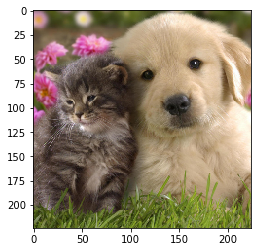

In [45]:
#deprocess and show, one line :)
from pretrained_lenet import MEAN_VALUES
plt.imshow(np.transpose((img[0] + MEAN_VALUES)[::-1],[1,2,0]).astype('uint8'))

## Generate caption

In [46]:
last_word_probas_det = get_output(predicted_probabilities,deterministic=False)[:,-1]

get_probs = theano.function([image_vectors,sentences], last_word_probas_det)

#this is exactly the generation function from week5 classwork,
#except now we condition on image features instead of words
def generate_caption(image,caption_prefix = ("START",),t=1,sample=True,max_len=100):
    image_features = get_cnn_features(image)
    caption = list(caption_prefix)
    for _ in range(max_len):
        
        next_word_probs = get_probs(image_features,as_matrix([caption]) ).ravel()
        #apply temperature
        next_word_probs = next_word_probs**t / np.sum(next_word_probs**t)

        if sample:
            next_word = np.random.choice(vocab,p=next_word_probs) 
        else:
            next_word = vocab[np.argmax(next_word_probs)]

        caption.append(next_word)

        if next_word=="#END#":
            break
            
    return caption

In [53]:
for i in range(10):
    print ' '.join(generate_caption(img,t=1.)[1:-1])

a close up of a cat in a cage
small stuffed animal and babies are playing around near a wall
a mother cat sitting on string of a tree with something in it
a small furry bear sniffing yellow apple note sits on a sill
orange and white birds are playing on a paper bench
a dog is sitting on top of a very colorful bed
mason fluffy wholly teddy bear at a image
a large white cat and a cute children play a upward together
a bear is outside with their feathers on its pencils
teddy bear lying on separated of things in the bunny seat


# Bonus Part
- Use ResNet Instead of GoogLeNet
- Use W2V as embedding
- Use Attention :) 

# Pass Assignment https://goo.gl/forms/2qqVtfepn0t1aDgh1 